# Створення нейронної мережі виявлення маски
Описати алгоритм дій

In [17]:
# імпортуємо потрібні модулі
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [18]:
# ініціалізужмо початковий рівень тренування, кількість епох тренування,
# та розмір партії картинок

#deprecated
#INIT_LR = 1e-4
#EPOCHS = 20  #20
#BS = 32

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9)

PATH_DATASET = "../dataset"
PATH_MASK_DETECTOR_MODEL = "../mask_detector.h5"

In [19]:
# підготуємо дані для тренування
data = []
labels = []

# пропустимо через цикл всі шляхи до картинок
for root, dirs, files in os.walk(PATH_DATASET):
    for filename in files:
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            # добудемо лейбл класу з назви файлу
            label = root.split(os.path.sep)[-1]
            # загрузимо вхідну картинку (224х224) та опрацюємо її
            image = load_img(os.path.join(root, filename), target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            # обновимо списки даних та лейблів
            data.append(image)
            labels.append(label)
        
        
    
# конвертуємо списки даних та лейблів в масив NumPy
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [20]:
# будуємо модель
# виконаємо одноразове кодування на лейблах
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# розділемо дані у відношенні 80 : 20 для тренування
# та тестування відповідно
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# побудуємо аугментатор зображення для тренування мережі
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# загрузимо мережу MobileNetV2, впевнимося що ми не використовуємо 
# голову моделі
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# побудуємо нашу голову моделі, яка буде встановленa на MobileNetV2
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# вставновлюємо голову на базову модель (це стане
# моделлю яку ми і будемо тренувати)
model = Model(inputs=baseModel.input, outputs=headModel)
# пропустимо через цикл всі слої базової моделі, і заморозимо їх,
# щоб вони не оновлювались під час тренування
for layer in baseModel.layers:
    layer.trainable = False


/tmp/ipykernel_175717/3367280221.py:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


In [ ]:
# тренуємо модель
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(
    aug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=20
)

predIdxs = model.predict(testX, batch_size=32)
# для кожного зображення в тестовому сеті нам потрібно отримамати індекс 
# лейбла з найбільшою відповідною передбаченною відповідностю
predIdxs = np.argmax(predIdxs, axis=1)
# показуємо відформатовані результати тренування моделі
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))
# зберігаємо модель
model.save(PATH_MASK_DETECTOR_MODEL)


Epoch 1/20


/home/prince0fpersik/playground/mask_detector/mask_detector_venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 532ms/step - accuracy: 0.8507 - loss: 0.3322 - val_accuracy: 0.9928 - val_loss: 0.0149
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20


2024-03-27 15:07:58.015534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-27 15:07:58.027468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.9949 - loss: 0.0218 - val_accuracy: 0.9928 - val_loss: 0.0144
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20


2024-03-27 15:08:18.468548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-27 15:08:18.472779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 505ms/step - accuracy: 0.9888 - loss: 0.0233 - val_accuracy: 0.9928 - val_loss: 0.0152
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20


2024-03-27 15:08:37.310509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-27 15:08:37.315064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 482ms/step - accuracy: 0.9935 - loss: 0.0176 - val_accuracy: 0.9928 - val_loss: 0.0198
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20


2024-03-27 15:08:55.400028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-27 15:08:55.404545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 484ms/step - accuracy: 0.9977 - loss: 0.0078 - val_accuracy: 0.9964 - val_loss: 0.0082
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/20


2024-03-27 15:09:13.382606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-27 15:09:13.387142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 481ms/step - accuracy: 0.9995 - loss: 0.0043 - val_accuracy: 0.9964 - val_loss: 0.0102
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/20


2024-03-27 15:09:31.284248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-27 15:09:31.288483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 492ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9964 - val_loss: 0.0084
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/20


2024-03-27 15:09:49.718526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-27 15:09:49.722716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 481ms/step - accuracy: 0.9997 - loss: 0.0061 - val_accuracy: 0.9928 - val_loss: 0.0168
Epoch 16/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/20


2024-03-27 15:10:07.883961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-27 15:10:07.888446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9960 - loss: 0.0094

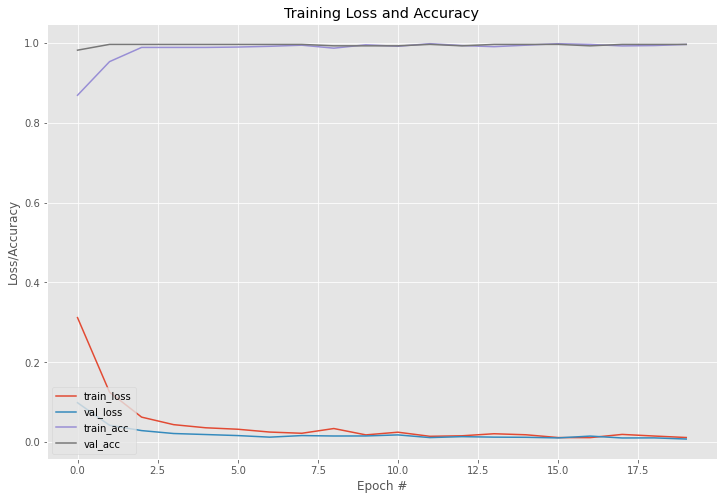

In [6]:
# побудуємо графік втрат та точності
N = EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)



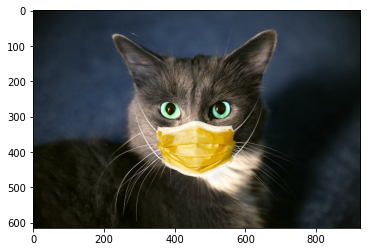

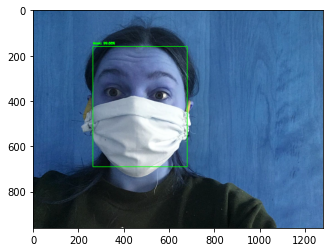

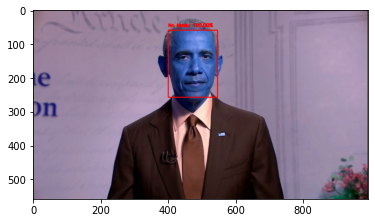

In [4]:
# протестуємо модель на деяких зображеннях
import cv2
from tensorflow.keras.models import load_model


PATH_FACE_DETECTOR_MODEL = "../face_detector"

prototxt_path = os.path.join(PATH_FACE_DETECTOR_MODEL, "deploy.prototxt")
weights_path = os.path.join(PATH_FACE_DETECTOR_MODEL, "res10_300x300_ssd_iter_140000.caffemodel")
net = cv2.dnn.readNet(prototxt_path, weights_path)

# завантажимо модель детектора масок з диска
model = load_model(PATH_MASK_DETECTOR_MODEL)

for filename in ["sample0.jpeg", "sample7.jpeg", "sample9.jpeg"]:
    if filename.endswith(".jpeg") or filename.endswith(".jpg"):
        
        # завантажимо вхідне зображення, клонуємо його, і візьмемо просторові розміри
        # зображення
        image = cv2.imread(os.path.join("../examples/", filename))
        orig = image.copy()
        (h, w) = image.shape[:2]
        # побудуємо blob(binary large object) з зображення
        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
        # пропустимо blob через мережу та знайдемо обличчя
        net.setInput(blob)
        detections = net.forward()

        # пропустимо через цикл знайдені обличчя 
        for i in range(0, detections.shape[2]):
            # добудемо впевненість (іними словами - ймовірність) пов'язану з
            # обличчам
            confidence = detections[0, 0, i, 2]
            # відфільтруємо знайдені обличчя з низькою ймовірністю перевіряючи
            # значення впевненості з пороговим
            if confidence > 0.5:
                # вирахуємо (x, y)-координати межей об'єкту
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                # впевнимося що межі знайденого обличчя лежать в кадрі
                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

                # визначимо позицію обличчя
                face = image[startY:endY, startX:endX]
                # перевіремо чи розмір обличчя більше 0
                if face.shape[0] > 0 and face.shape[1] > 0:
                    # конвертуємо його з BGR до RGB, змінемо розмір до 224х224, та опрацюємо його
                    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                    face = cv2.resize(face, (224, 224))
                    face = img_to_array(face)
                    face = preprocess_input(face)
                    face = np.expand_dims(face, axis=0)
                    # пропустимо обличчя через модель для визначення, чи найявна на ньому маска
                    (mask, withoutMask) = model.predict(face)[0]

                    # визначимо лейбл зображення, для того щоб отримати колір для
                    # тексту та межей зображення
                    label = "Mask" if mask > withoutMask else "No Mask"
                    color = (0, 255, 0) if label == "Mask" else (255, 0, 0)
                    # вкажемо ймовірність в тексті
                    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
                    # зображемо лейбл та межі чотирикутнмком на кадрі результату
                    cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
                    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        # покажемо зображення
        plt.imshow(image)
        plt.show()
